##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [46]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os  
try:pool.close()
except:pass

# Model

In [47]:

MP=False
Scope = 'Test'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fch4'
Inputs=['Sedge','VWC','Temp','wind_speed']
#     for FillVar in ['fco2','fch4']:
# Runs,params = Dense.Params(Scope,target,MP)
params = Dense.Params(Scope,target,MP)

params['Dpath'] = cwd+'/'+Site+'/'
params['Spath'] = params['Dpath']+'/TempWeights/'
params['Sname'] = 'Test'
params['Inputs'] = Inputs
params['Model'] = '+'.join(params['Inputs'])

# params['Loss']='mean_absolute_error'

if __name__ == '__main__':
    if params['proc']>1:
        pool = Pool(processes=3,maxtasksperchild=75)
    else:
        pool = None
    
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',resample='3H')
    RST.Scale(params['target'],params['Inputs'])
    y = RST.y*1.0
    X = RST.X*1.0
    
    params['N']=int(y.shape[0]/30)
    print(y.shape,params['N'])
    
    Y_hat_train,Y_hat_val,y_true2,X_true2,count_train,count_val = Dense.RunNN(params,X,y,RST.YScaled,RST.XScaled,pool)
#     Y_hat,y_true = np.squeeze(Y_hat),np.squeeze(y_true)
    
    

    if pool is not None:
        pool.close()
      
    
print('Done!!')

(191,) 6
0.9500000000000001
Epoch 00133: early stopping
Saved model to disk
Epoch 00066: early stopping
Epoch 00006: early stopping
Epoch 00090: early stopping
Epoch 00150: early stopping
Epoch 00026: early stopping
[[0.16522862 0.09815117 0.12940185 ...        nan 0.49370414 0.64209616]
 [0.56278563 0.55726528 0.56241918 ... 0.68326098 0.76684207 0.7817018 ]
 [0.10663193 0.1646028  0.13493611 ... 0.7314837  0.88678944 0.96796006]
 [0.43163058 0.40202823 0.41650301 ... 0.28011534 0.48551399 0.60909951]
 [0.32054371 0.23781915 0.26321068 ... 0.53030634 0.67087811 0.73842973]
 [0.16697238 0.32219478 0.23038034 ... 0.8287546  0.837556   0.91742051]] [[       nan        nan        nan ... 0.44308868        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan    

# Sorting

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in maximum
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


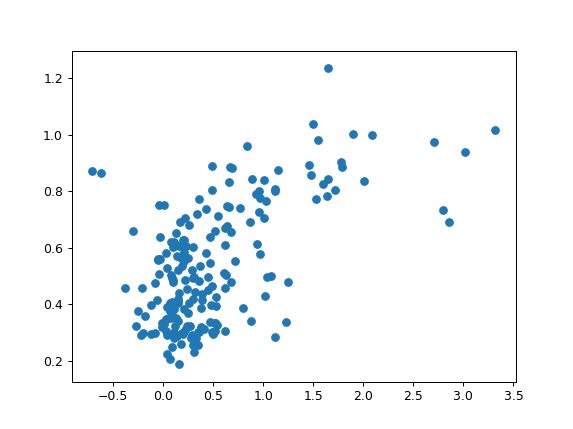

0.08900069166168131
0.28237582990187593
0.5031901216720782 0.5373171057409881


In [50]:

# Y_hat_train,Y_hat_val,y_true2,X_true2,count_train,
#     count_val=Dense.Sort(Y_hat,y_true,X_true,index,ones)    
    
Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)
Y_hat_val_bar=np.nanmean(Y_hat_val,axis=0)
Y_hat_train_var = 1/(np.nansum(count_train)-1)*np.nansum((Y_hat_train - Y_hat_train_bar)**2,axis=0)
Y_hat_val_var = 1/(np.nansum(count_val)-1)*np.nansum((Y_hat_val - Y_hat_val_bar)**2,axis=0)
r2_train = np.maximum((y_true2[0,:]-Y_hat_train_bar)**2-Y_hat_train_var,0)
r2_val = np.maximum((y_true2[0,:]-Y_hat_val_bar)**2-Y_hat_val_var,0)


plt.figure()
plt.scatter(y_true2[0,:],Y_hat_train_bar)
print(metrics.mean_squared_error(y_true2[0,:],Y_hat_train_bar)**2)
print(metrics.r2_score(y_true2[0,:],Y_hat_train_bar))
print(y_true2[0,:].mean(),Y_hat_train_bar.mean())


# CI and PI

In [5]:

importlib.reload(Dense)


params['Loss'] = 'Boot_Loss'
params['Validate'] = False
params['Sname'] = 'Var'
params['Save']['Model'] = True

y = r2_val
Valid = np.where(np.isnan(y)==False)
y = y[Valid]
X = X_true2[Valid]

YStandard = MinMaxScaler(feature_range=(.1, 1))
XStandard = StandardScaler()
YScaled = YStandard.fit(y.reshape(-1, 1))
XScaled = XStandard.fit(X)#.reshape(-1, 1))
y = YScaled.transform(y.reshape(-1, 1))
X = XScaled.transform(X)
init=1#int(np.random.rand(1)[0]*100)
Y_hat_var,y_true_var,X_true_var,index_var,ones_var = Dense.TTV_Split(init,params,X,y)
print(Y_hat_var.shape,y_true_var.shape)
Y_hat_var = YScaled.inverse_transform(Y_hat_var.reshape(-1,1))
y_true_var = YScaled.inverse_transform(y_true_var.reshape(-1,1))
# plt.figure()
# plt.scatter(Y_hat_var,y_true_var)
# plt.ylabel('True')
# plt.xlabel('prd')

C:\Anaconda3\lib\site-packages\keras\callbacks.py:499: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Anaconda3\lib\site-packages\keras\callbacks.py:407: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Saved model to disk
(88, 1) (88, 1)


# Map Results

(191, 4)


<IPython.core.display.Javascript object>


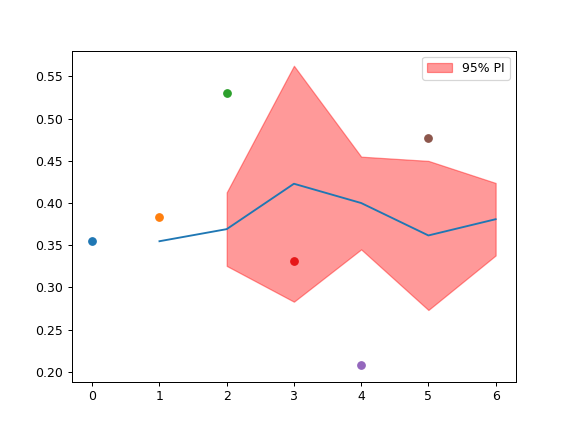

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


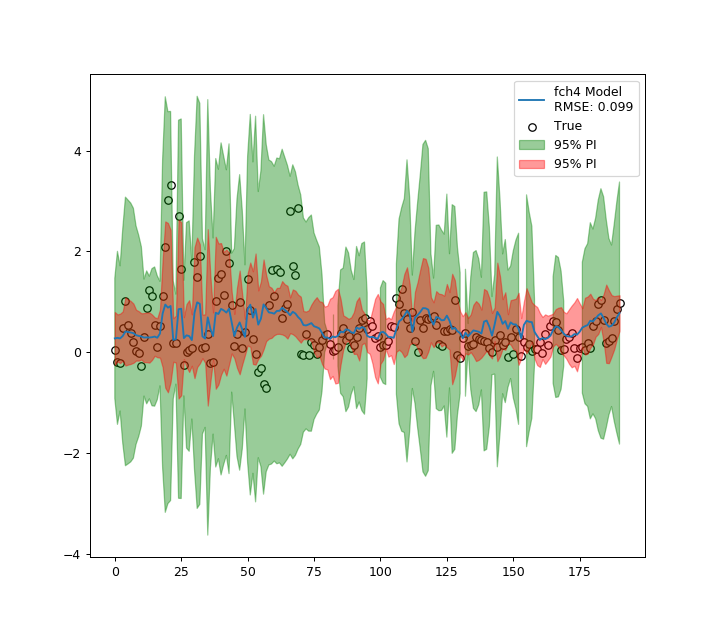

In [12]:
X = RST.XScaled.transform(X_true2)
print(X.shape)
params['Sname']='Test'
params['Loss']='mean_absolute_error'
Y_fill = []
plt.figure()
MSE = []
for i in range(params['K']):
    params['iteration']=i
    Empty_Mod = Dense.Load_Model(params)
    Model = Dense.Load_Weights(Empty_Mod,params) 
    Y = RST.YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
    mse = (metrics.mean_squared_error(y_true2[0,:],Y))
    Y_fill.append(Y)
    plt.scatter(i,mse)
    MSE.append(mse)
Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
Y_fill_bar = Y_fill.mean(axis=0)
MSE = np.asanyarray(MSE)
idtmp = np.arange(0,i+1)+1
cumsum = np.cumsum(MSE)/idtmp
cum_std = cumsum.copy()
for j in range(i+1):
    cum_std[j] = ((cumsum[j]-MSE[j])**2/j)**.5
plt.plot(idtmp,cumsum)
# plt.plot(idtmp,cum_std)
CI = stats.t.ppf(1-0.025,idtmp)*(cum_std/(idtmp)**.5)
plt.fill_between(idtmp, cumsum-CI, 
                 cumsum+CI,  color = 'red', alpha = 0.4, 
                 label = '95% PI')
plt.legend()

params['Sname']='Var'
params['iteration']=1
params['Loss']='Boot_Loss'
Empty_Mod = Dense.Load_Model(params)
Model = Dense.Load_Weights(Empty_Mod,params) 
YVar=YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
X_back = np.squeeze(XScaled.inverse_transform(X))

# plt.figure()
# plt.plot(Yfill)
Data = pd.DataFrame(data=X_back,columns=params['Inputs'])
Data[target] = np.squeeze(Y_fill_bar)
Data['True'] = np.squeeze(y_true2[0,:])
# Data = pd.DataFrame({'PPFD':X_back,Target:np.squeeze(Yfill),'Var':np.squeeze(YVar)})
Data['SE'] = 1/(params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
Data['Var'] = np.squeeze(YVar)
Data['CI']=stats.t.ppf(1-0.025,params['K'])*(Data['SE'])**.5
Data['PI']=stats.t.ppf(1-0.025,params['K'])*((Data['Var']+Data['SE'])**.5) #the accuracy of our estimate with respect to the observed output
Map_Val='VWC'
plt.figure(figsize=(8,7))

plt.scatter(Data.index,Data['True'],edgecolor='black',facecolor='white')
plt.plot(Data.index,Data[target],label=
        params['target']+' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
                                                                   Data[params['target']])**2,3)))
plt.fill_between(Data.index, Data[target]-Data['PI'], 
                 Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
                 label = '95% PI')
plt.fill_between(Data.index, Data[target]-Data['CI'], 
                 Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
                 label = '95% PI')
plt.legend()

# The "Optimum" Sized Model

In [ ]:
# pool.close()
# Site = 'Illisarvik'#'FishIsland'#
Scope = 'Test'
cwd = os.getcwd()
def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
#         BaseFactors = ['Sedge','Shrub','Grass','Sparse','Out_of_Basin']
#         BaseFactors = []
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

# def Params(Func,Y,MP = True):
#     params = {}
#     params['proc']=3
#     if MP == False:
#         params['proc']=1
#     if Func == 'Full':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(200,20,10,dtype='int32')
#     elif Func == 'Test':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(70,10,5,dtype='int32')
#     N = np.repeat(N,K)
#     d = {'N':N.astype(int)}
#     Runs = pd.DataFrame(data=d)
#     Runs['MAE'] = 0.0
#     Runs['R2'] = 0.0
#     Runs['Model']=0
#     params['K'] = K
#     params['epochs'] = epochs
#     params['Y'] = Y
#     params['splits_per_mod'] = splits_per_mod
#     params['Save'] = {}
#     params['Save']['Weights']=False
#     params['Save']['Model']=False
    
#     return(Runs,params)


# MP=False

# if Scope == 'Full':
#     MP = True
# if __name__=='__main__'and MP==True:
#     pool = Pool(processes=3,maxtasksperchild=75)
# else:pool=None
    
# # for Site in ['Illisarvik','FishIsland']:
# Site='Illisarvik'
# FillVar = 'fco2'
# #     for FillVar in ['fco2','fch4']:
# Runs,params = MF.Params(Scope,FillVar,MP)
# FullModel = ModSelect(Scope,Site)
# print(FullModel)
# params['Dpath'] = cwd+'/'+Site+'/'
# params['Prelim_N']=True
# Best,Scores,ModelRuns = MF.FactorTest(params,FullModel,Runs)
# print(Best,Scores)
# Scores,ModelRuns = Best_Fill(Best,Runs,Scores,params)
# Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
# ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')

# if __name__=='__main__'and MP==True:
#     pool.close()

In [ ]:
# Grp = Scores.groupby('Model').mean()
# Grp['SE'] = Scores[['Model','MAE']].groupby('Model').sem()
# # Grp['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
# print(Grp)
# # plt.bar(Grp.index,Grp['MAE'],yerr=Grp['SE'])

In [ ]:
print('kitty')